In [1]:
from tensorflow import keras
import pickle
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import seaborn as sns
import pickle
import functools
import fastdtw
import scipy.spatial.distance as sd
import functools
import matplotlib.pyplot as plt
import seaborn as sns

2022-03-02 00:30:17.752948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 00:30:17.752974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Importing solar and wind dataframes
solar_df = pd.read_csv('Final Datasets/solar_energy_generation.csv')
wind_df = pd.read_csv('Final Datasets/wind_energy_generation.csv')

In [3]:
# Removing unnecessary columns
solar_df = solar_df[['timestamp', 'GHI_KWh',
       'Clearsky GHI_KWh', 'Solar Energy', 'Clearsky Solar Energy']]
# Renaming columns for the lineplot
solar_df.rename(columns = {'GHI_KWh':'Global Horizontal Irradiance',
                          'Clearsky GHI_KWh': 'Clearsky Global Horizontal Irradiance'}, inplace = True)
# Converting timestamp from string to pd.datetime format
solar_df['timestamp'] = pd.to_datetime(solar_df['timestamp'])
# Limiting solar dataset to 2017
solar_df = solar_df[solar_df['timestamp'] >= pd.Timestamp("2017-01-01 00:00:00")]
solar_df = solar_df[solar_df['timestamp'] < pd.Timestamp("2018-01-01 00:00:00")]
# Setting the index to timestamp
solar_df = solar_df.set_index('timestamp')
solar_df

,Global Horizontal Irradiance,Clearsky Global Horizontal Irradiance,Solar Energy,Clearsky Solar Energy
timestamp,,,,
2017-01-01 00:00:00,0.0,0.0,0.0,0.0
2017-01-01 00:30:00,0.0,0.0,0.0,0.0
2017-01-01 01:00:00,0.0,0.0,0.0,0.0
2017-01-01 01:30:00,0.0,0.0,0.0,0.0
2017-01-01 02:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2017-12-31 21:30:00,0.0,0.0,0.0,0.0
2017-12-31 22:00:00,0.0,0.0,0.0,0.0
2017-12-31 22:30:00,0.0,0.0,0.0,0.0


In [4]:
# I have used this post on Stackoverflow to plot multiple graphs 
# https://stackoverflow.com/a/38305181
def plot_solar(df, size=(8, 6)):
    figs = {}
    axs = {}
    for idx, feature in enumerate(df.keys()):
        figs[idx] = plt.figure(figsize = size)
        axs[idx] = figs[idx].add_subplot(111)
        axs[idx].plot(df[feature], label=feature)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel('KWh')
        axs[idx].legend()
    return figs, axs

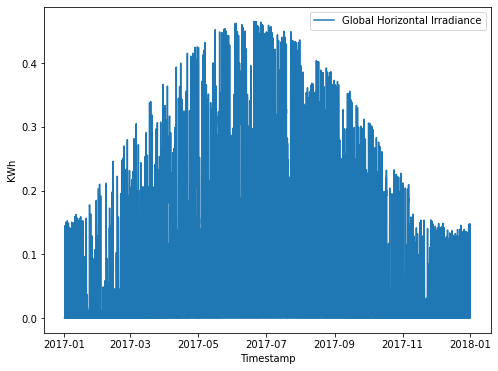

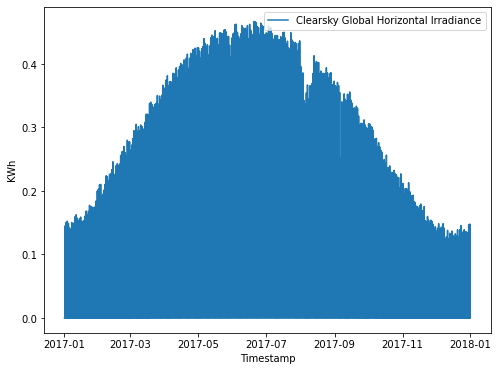

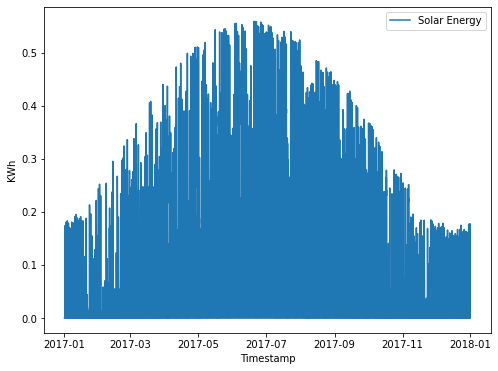

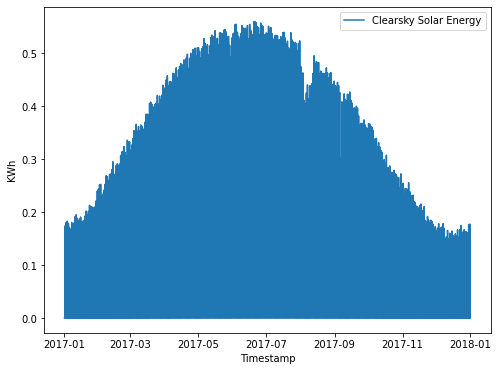

In [5]:
# Plotting line graphs on an annual scale
figs, axs = plot_solar(solar_df)

In [6]:
# Aggregating solar df to weekly datapoints and summing values for each week
solar_df
solar_weekly_df = solar_df.resample('W').sum()
solar_weekly_df.head()

,Global Horizontal Irradiance,Clearsky Global Horizontal Irradiance,Solar Energy,Clearsky Solar Energy
timestamp,,,,
2017-01-01,1.4260,1.4260,1.7112,1.7112
2017-01-08,10.2445,10.2445,12.2934,12.2934
2017-01-15,11.1875,11.1875,13.4250,13.4250
2017-01-22,6.9185,11.6970,8.3022,14.0364
2017-01-29,6.8310,13.4020,8.1972,16.0824


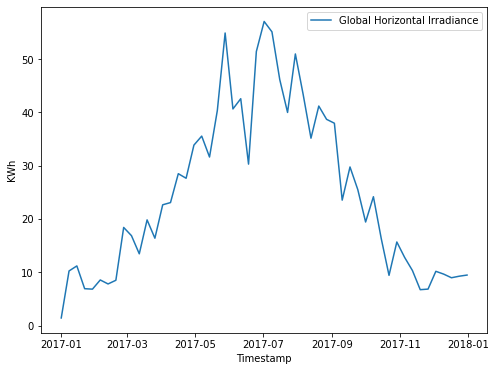

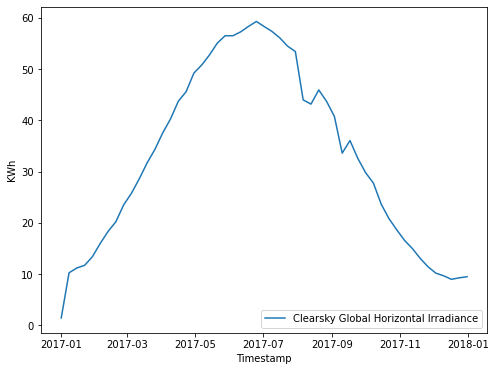

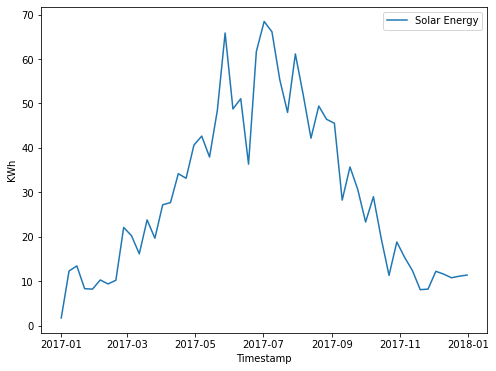

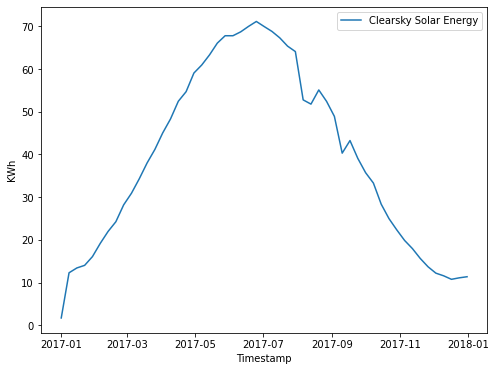

In [7]:
# Plotting annual line graphs with aggregated weekly datapoints
figs, axs = plot_solar(solar_weekly_df)

In [8]:
# Limiting solar df to December 2017
solar_df = solar_df[solar_df.index >= pd.Timestamp("2017-12-01 00:00:00")]
solar_df = solar_df[solar_df.index < pd.Timestamp("2018-01-01 00:00:00")]
solar_df

,Global Horizontal Irradiance,Clearsky Global Horizontal Irradiance,Solar Energy,Clearsky Solar Energy
timestamp,,,,
2017-12-01 00:00:00,0.0,0.0,0.0,0.0
2017-12-01 00:30:00,0.0,0.0,0.0,0.0
2017-12-01 01:00:00,0.0,0.0,0.0,0.0
2017-12-01 01:30:00,0.0,0.0,0.0,0.0
2017-12-01 02:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2017-12-31 21:30:00,0.0,0.0,0.0,0.0
2017-12-31 22:00:00,0.0,0.0,0.0,0.0
2017-12-31 22:30:00,0.0,0.0,0.0,0.0


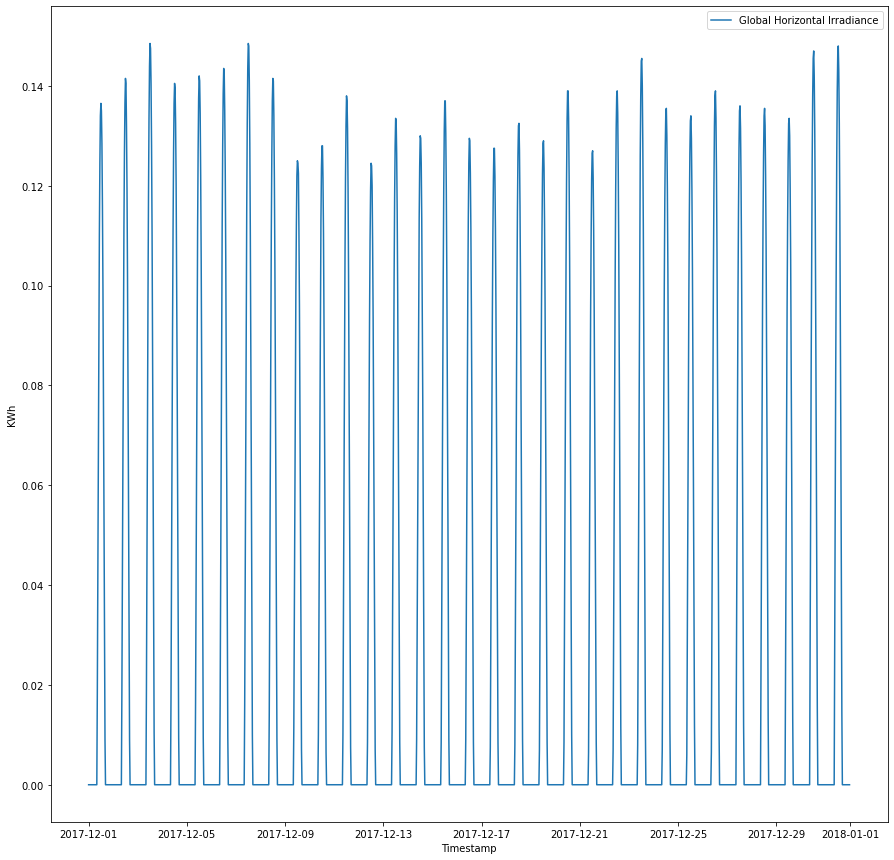

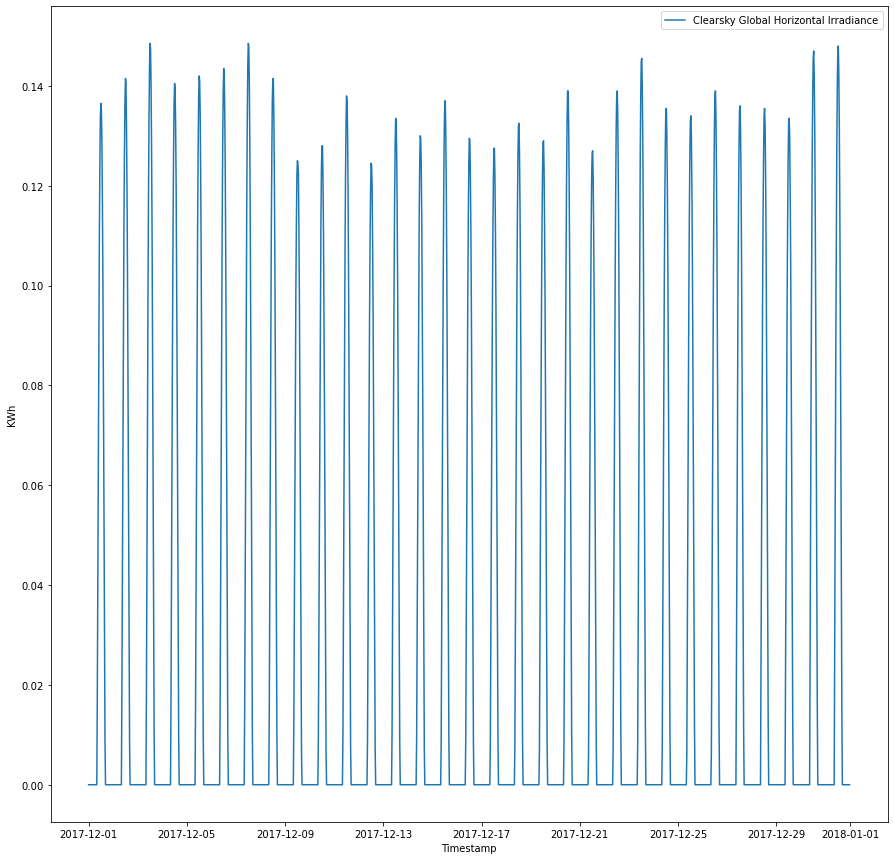

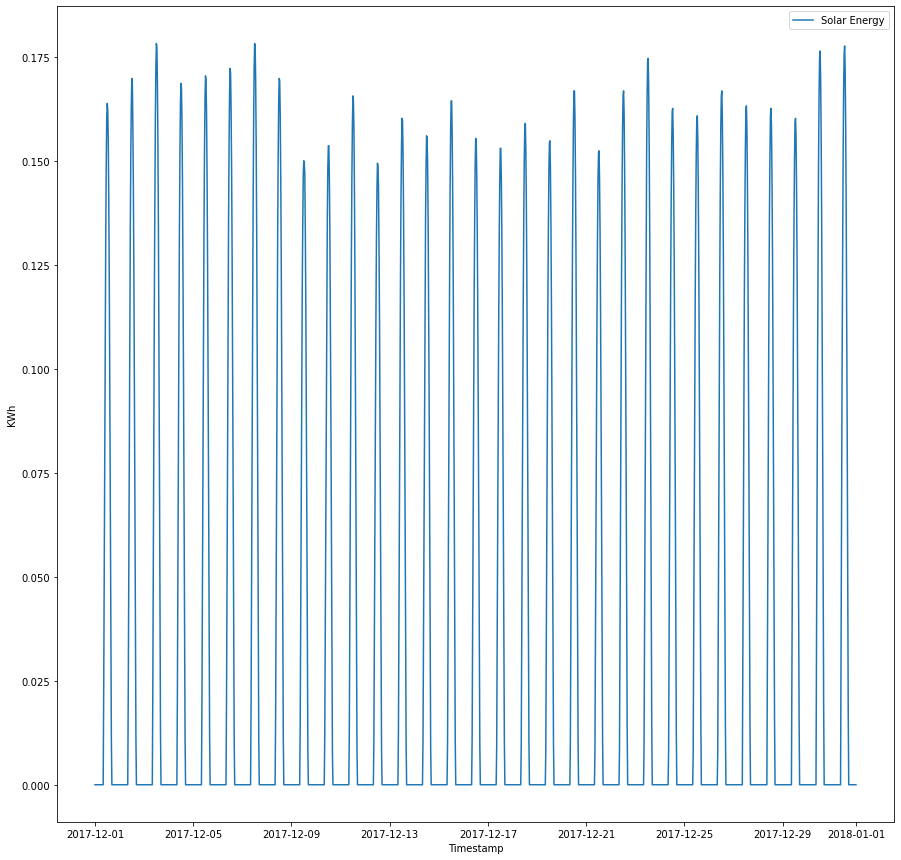

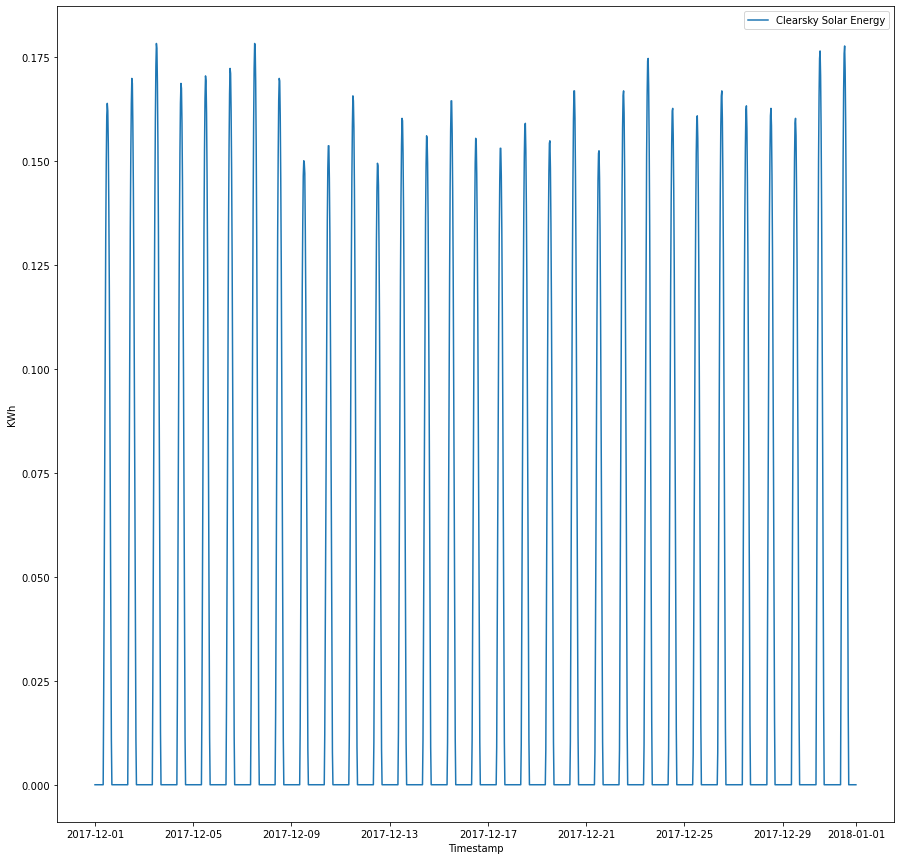

In [9]:
# Plotting line graphs for December 2017
figs, axs = plot_solar(solar_df, (15,15))

In [10]:
# Aggregating data points at every 6 hours
solar_df
solar_six_hour_df = solar_df.resample('6H').sum()
solar_six_hour_df

,Global Horizontal Irradiance,Clearsky Global Horizontal Irradiance,Solar Energy,Clearsky Solar Energy
timestamp,,,,
2017-12-01 00:00:00,0.0000,0.0000,0.0000,0.0000
2017-12-01 06:00:00,0.5875,0.5875,0.7050,0.7050
2017-12-01 12:00:00,0.7885,0.7885,0.9462,0.9462
2017-12-01 18:00:00,0.0000,0.0000,0.0000,0.0000
2017-12-02 00:00:00,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...
2017-12-30 18:00:00,0.0000,0.0000,0.0000,0.0000
2017-12-31 00:00:00,0.0000,0.0000,0.0000,0.0000
2017-12-31 06:00:00,0.5390,0.5390,0.6468,0.6468


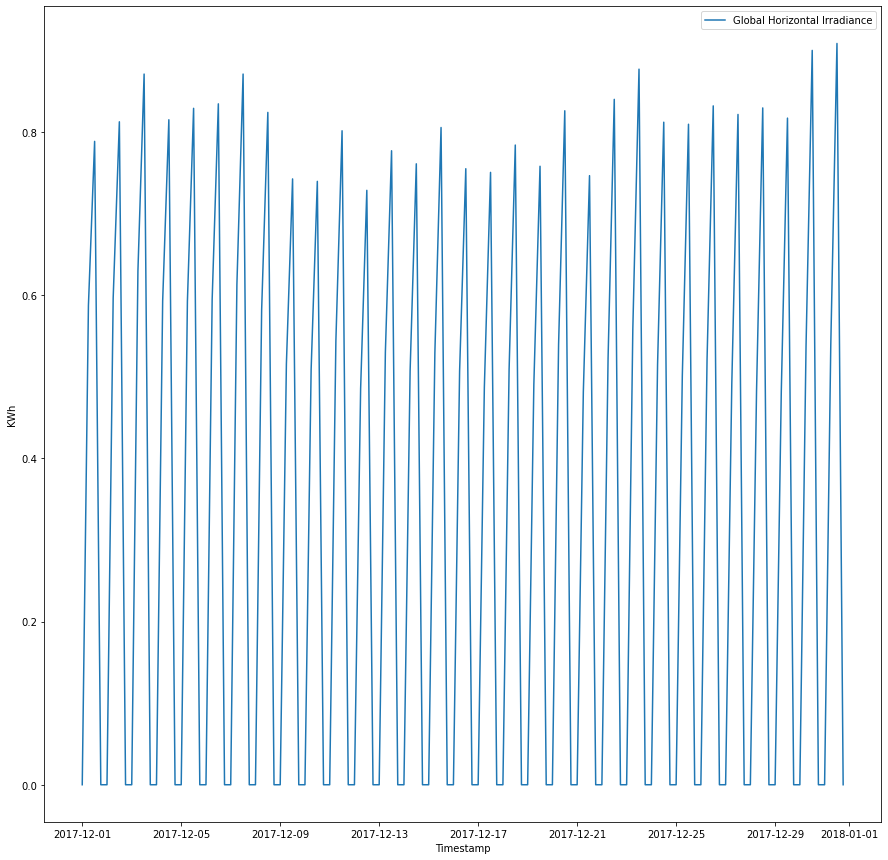

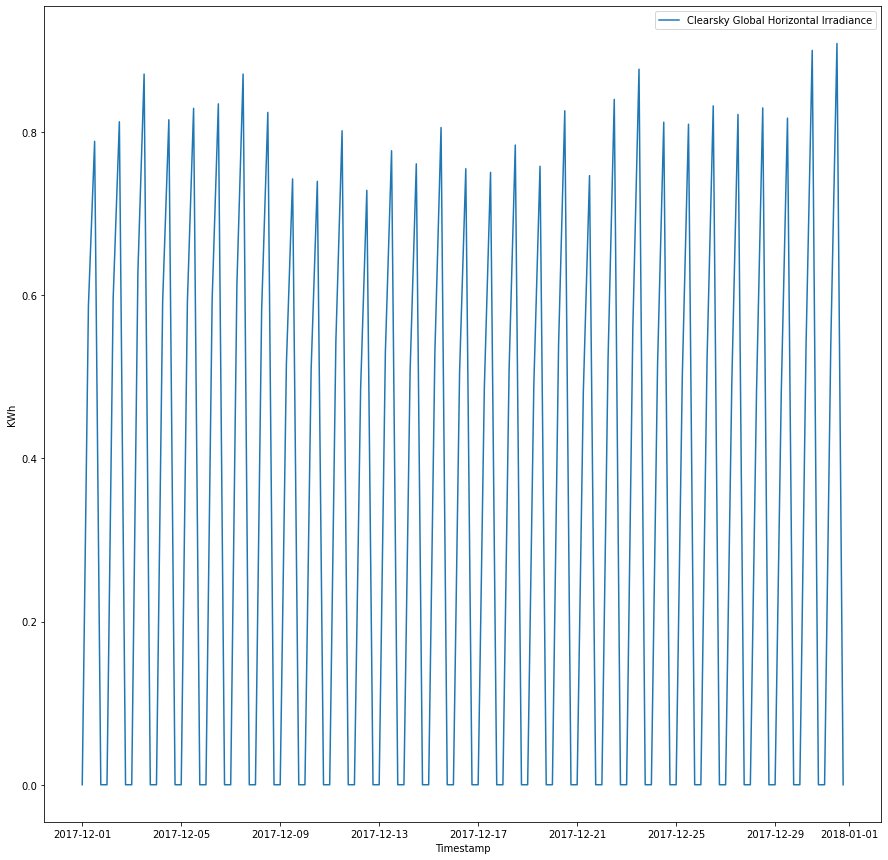

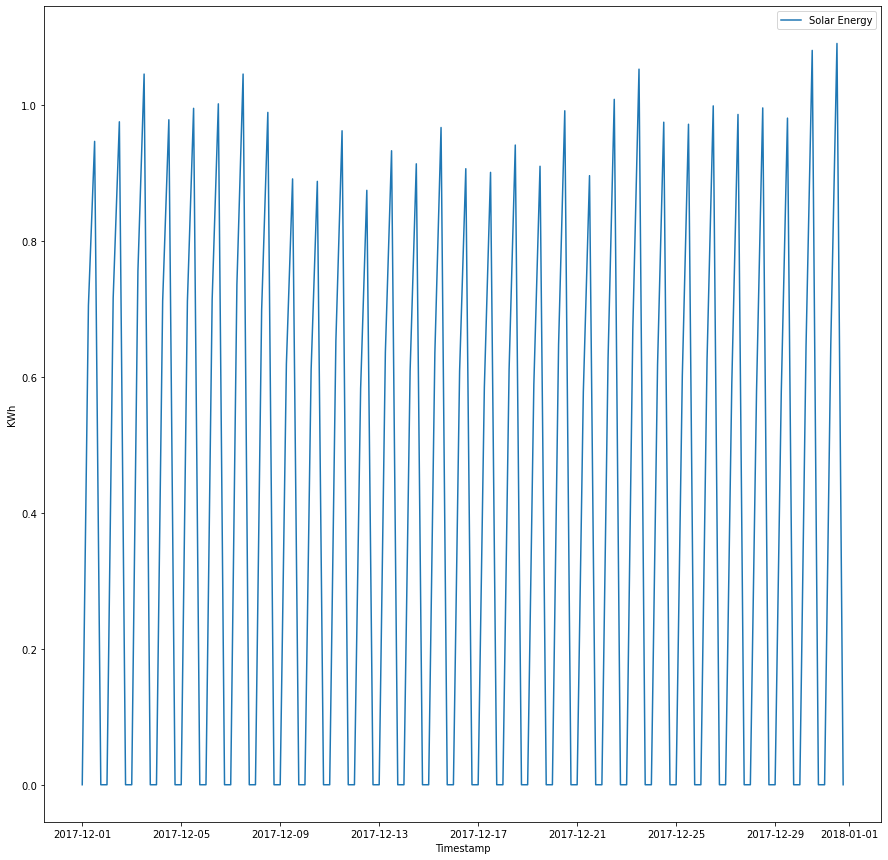

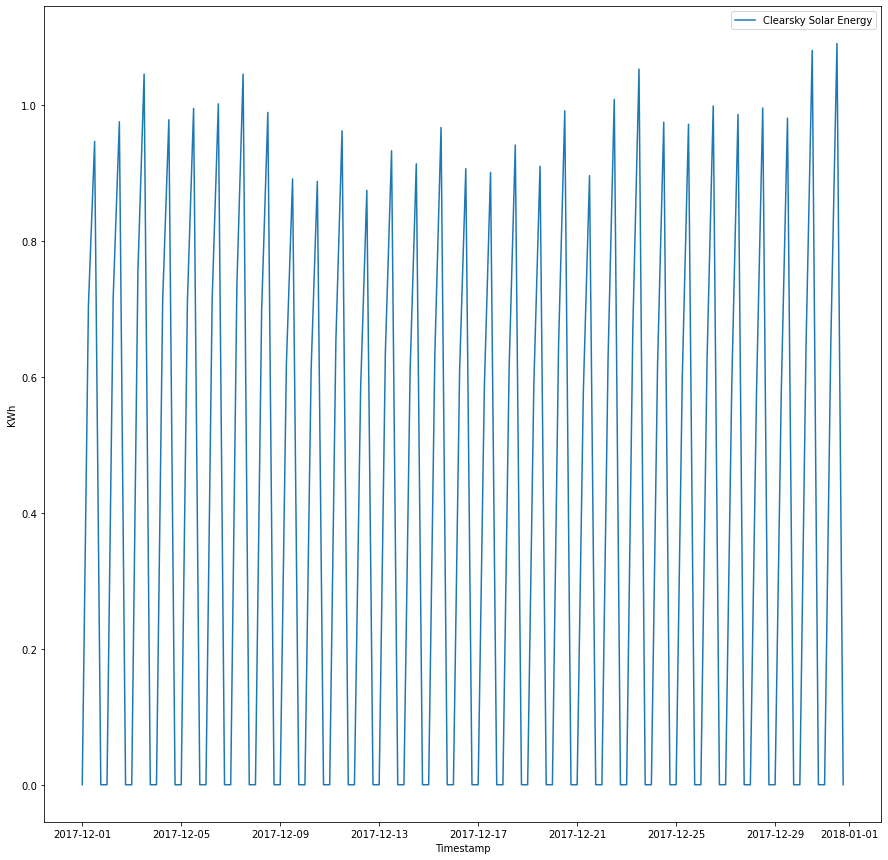

In [11]:
# Plotting monthly line graphs with aggregated datapoints
figs, axs = plot_solar(solar_six_hour_df, (15,15))

### Wind Dataframe Graphs

In [12]:
wind_df

,Unnamed: 0,timestamp,Pressure,Temperature,Wind Speed,Air Density,Wind Power,Wind Energy
0,0,2012-01-01 00:00:00,102000,275.15,0.5,1.291401,196.361452,0.098181
1,1,2012-01-01 00:30:00,102000,275.15,0.5,1.291401,196.361452,0.098181
2,2,2012-01-01 01:00:00,102000,275.15,0.5,1.291401,196.361452,0.098181
3,3,2012-01-01 01:30:00,102000,275.15,0.5,1.291401,196.361452,0.098181
4,4,2012-01-01 02:00:00,102000,275.15,0.5,1.291401,196.361452,0.098181
...,...,...,...,...,...,...,...,...
157819,157819,2020-12-31 21:30:00,100200,282.95,1.0,1.233640,1500.629881,0.750315
157820,157820,2020-12-31 22:00:00,100200,283.05,1.0,1.233204,1500.099716,0.750050
157821,157821,2020-12-31 22:30:00,100200,283.05,1.0,1.233204,1500.099716,0.750050
157822,157822,2020-12-31 23:00:00,100200,282.95,1.0,1.233640,1500.629881,0.750315


In [13]:
# Removing unnecessary columns
wind_df = wind_df[['timestamp', 'Pressure', 'Temperature', 'Wind Speed',
       'Air Density', 'Wind Power', 'Wind Energy']]
# Units of the features in the dataframe for y-labels
wind_feature_units = {'timestamp': 'time', 'Pressure':'Pa', 'Temperature':'Kelvin', 'Wind Speed':'m/s',
       'Air Density':'kg/m^3', 'Wind Power':'Watt', 'Wind Energy':'KWh'}
# Converting timestamp from string to pd.datetime format
wind_df['timestamp'] = pd.to_datetime(wind_df['timestamp'])
# Limiting wind dataset to 2017
wind_df = wind_df[wind_df['timestamp'] >= pd.Timestamp("2017-01-01 00:00:00")]
wind_df = wind_df[wind_df['timestamp'] < pd.Timestamp("2018-01-01 00:00:00")]
# Setting the index to timestamp
wind_df = wind_df.set_index('timestamp')
wind_df

/tmp/ipykernel_157458/4032359856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_df['timestamp'] = pd.to_datetime(wind_df['timestamp'])


,Pressure,Temperature,Wind Speed,Air Density,Wind Power,Wind Energy
timestamp,,,,,,
2017-01-01 00:00:00,101000,272.15,0.7,1.292836,539.414631,0.269707
2017-01-01 00:30:00,101000,272.15,0.7,1.292836,539.414631,0.269707
2017-01-01 01:00:00,101000,272.15,0.7,1.292836,539.414631,0.269707
2017-01-01 01:30:00,101000,272.15,0.7,1.292836,539.414631,0.269707
2017-01-01 02:00:00,101000,272.15,0.8,1.292836,805.190353,0.402595
...,...,...,...,...,...,...
2017-12-31 21:30:00,101000,273.15,0.7,1.288103,537.439838,0.268720
2017-12-31 22:00:00,101000,272.15,0.8,1.292836,805.190353,0.402595
2017-12-31 22:30:00,101000,272.15,0.7,1.292836,539.414631,0.269707


In [17]:
# I have used this post on Stackoverflow to plot multiple graphs 
# https://stackoverflow.com/a/38305181
def plot_wind(df, units, size=(8, 6)):
    figs = {}
    axs = {}
    for idx, feature in enumerate(df.keys()):
        figs[idx] = plt.figure(figsize = size)
        axs[idx] = figs[idx].add_subplot(111)
        axs[idx].plot(df[feature], label=feature)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel(units[feature])
        axs[idx].legend()
    return figs, axs

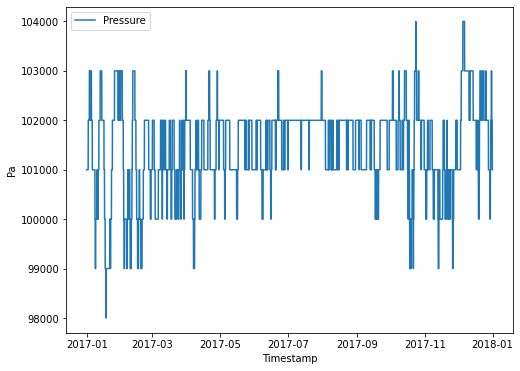

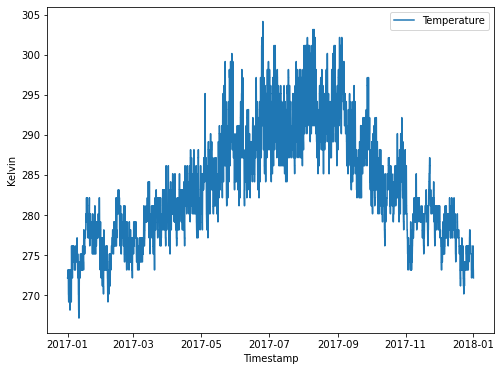

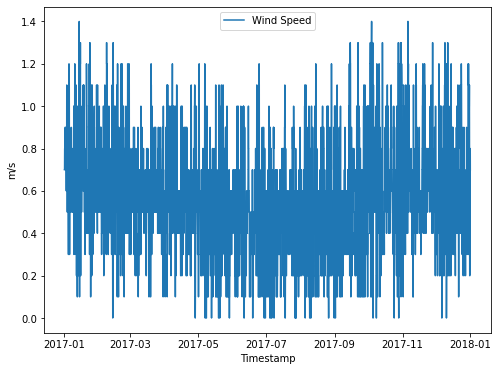

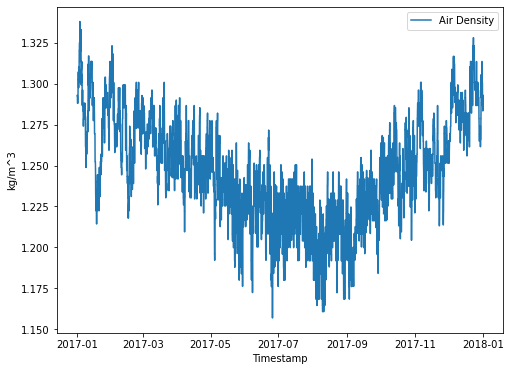

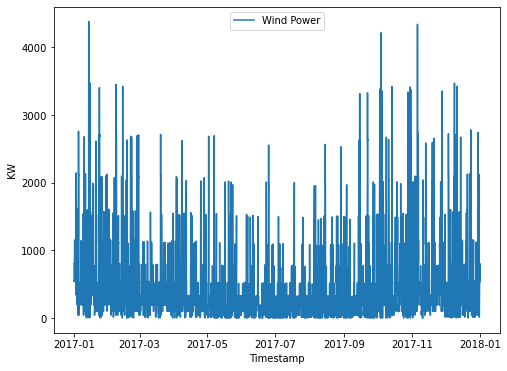

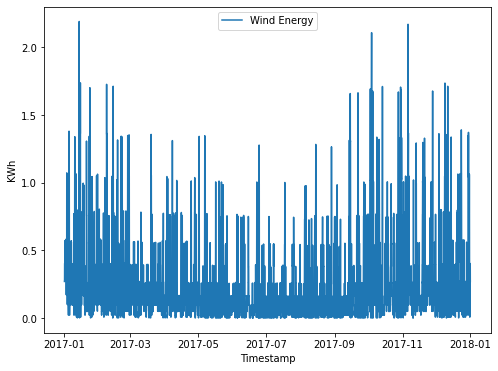

In [19]:
# Plotting line graphs on an annual scale
figs, axs = plot_wind(wind_df, wind_feature_units)

In [23]:
# Aggregating wind df to weekly datapoints and summing values for each week

wind_weekly_df = wind_df.resample('W').sum()
# Removing the first row because of incorrect values 
wind_weekly_df = wind_weekly_df.iloc[1: , :]

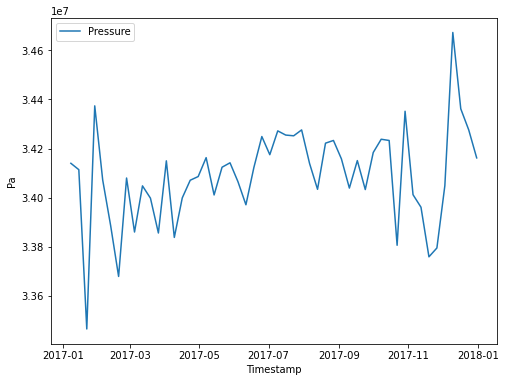

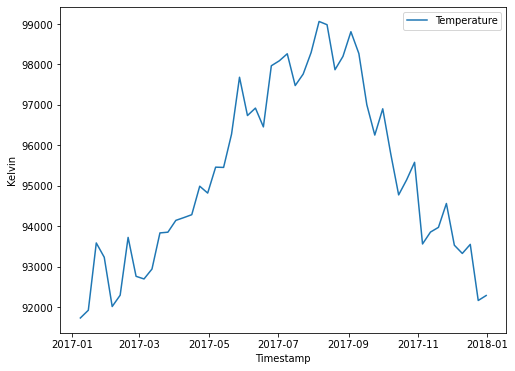

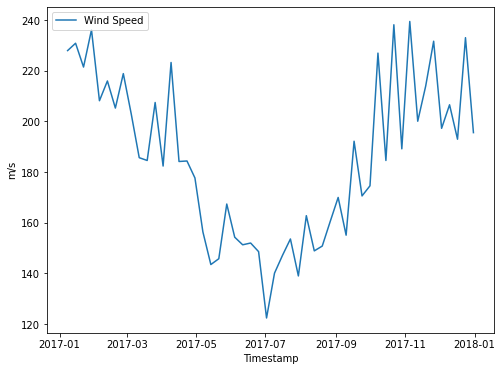

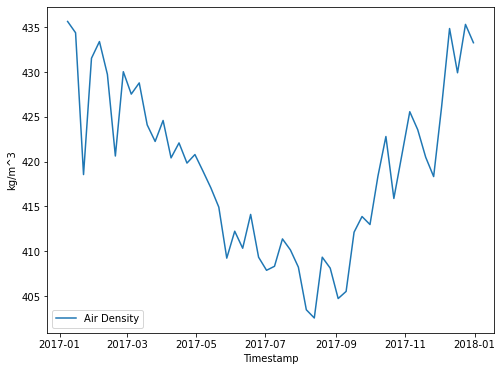

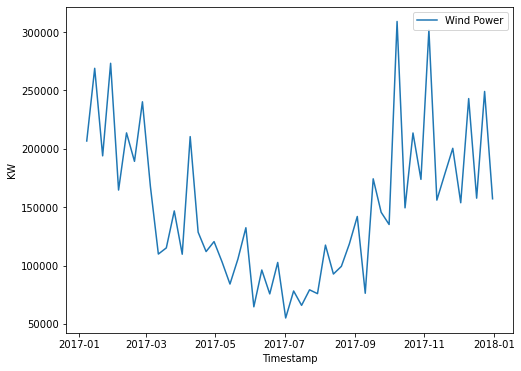

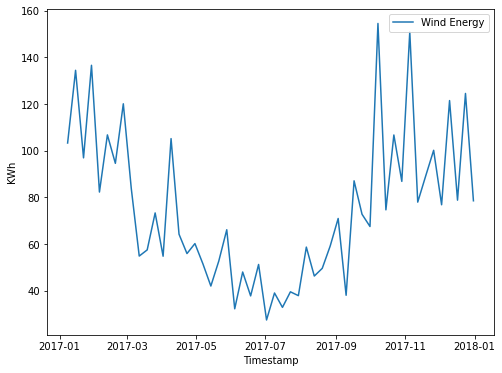

In [24]:
# Plotting annual line graphs with aggregated weekly datapoints
figs, axs = plot_wind(wind_weekly_df, wind_feature_units)

In [26]:
# Limiting wind df to December 2017
wind_df = wind_df[wind_df.index >= pd.Timestamp("2017-12-01 00:00:00")]
wind_df = wind_df[wind_df.index < pd.Timestamp("2018-01-01 00:00:00")]
wind_df

,Pressure,Temperature,Wind Speed,Air Density,Wind Power,Wind Energy
timestamp,,,,,,
2017-12-01 00:00:00,101000,279.15,0.6,1.260417,331.171579,0.165586
2017-12-01 00:30:00,101000,279.15,0.6,1.260417,331.171579,0.165586
2017-12-01 01:00:00,101000,279.15,0.7,1.260417,525.888203,0.262944
2017-12-01 01:30:00,101000,279.15,0.7,1.260417,525.888203,0.262944
2017-12-01 02:00:00,101000,279.15,0.7,1.260417,525.888203,0.262944
...,...,...,...,...,...,...
2017-12-31 21:30:00,101000,273.15,0.7,1.288103,537.439838,0.268720
2017-12-31 22:00:00,101000,272.15,0.8,1.292836,805.190353,0.402595
2017-12-31 22:30:00,101000,272.15,0.7,1.292836,539.414631,0.269707


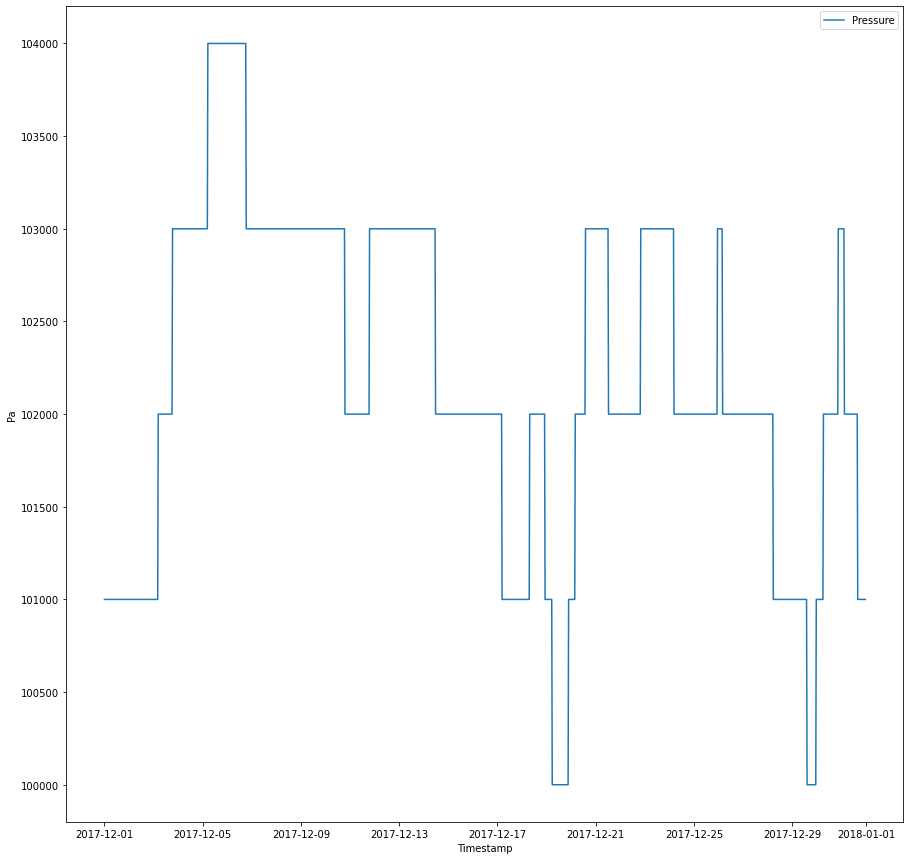

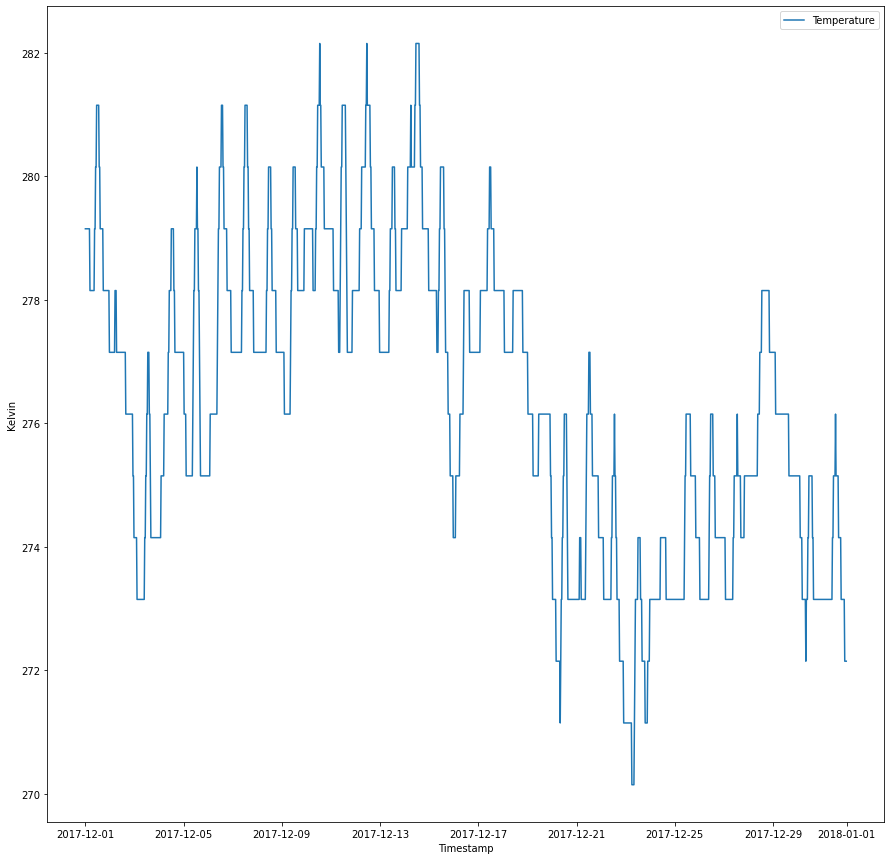

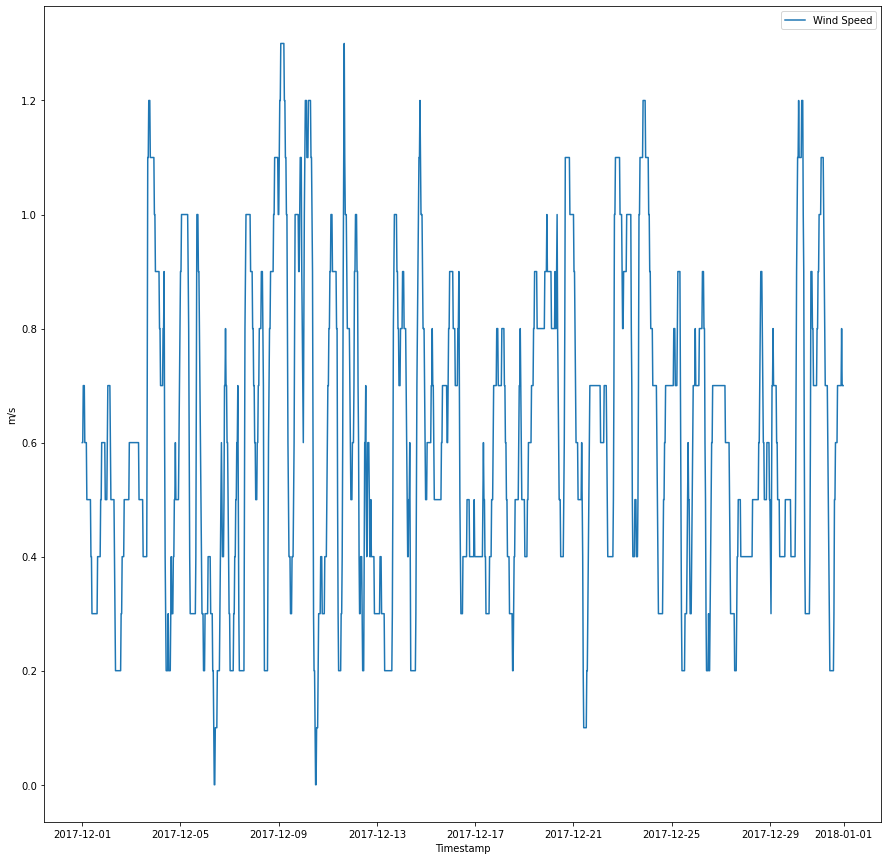

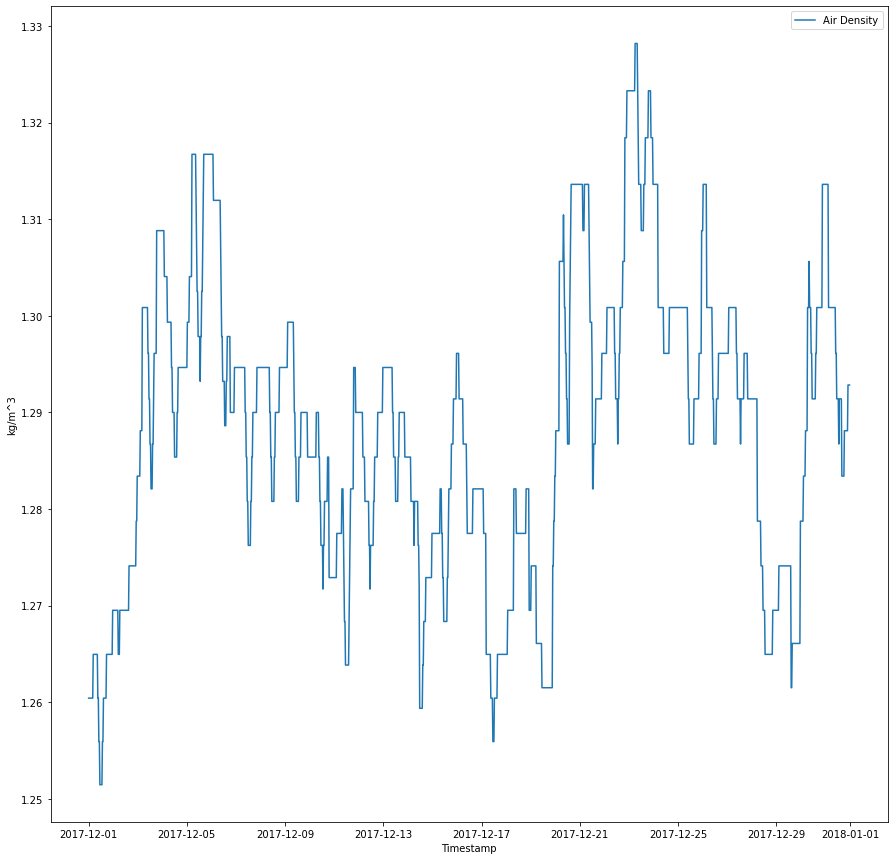

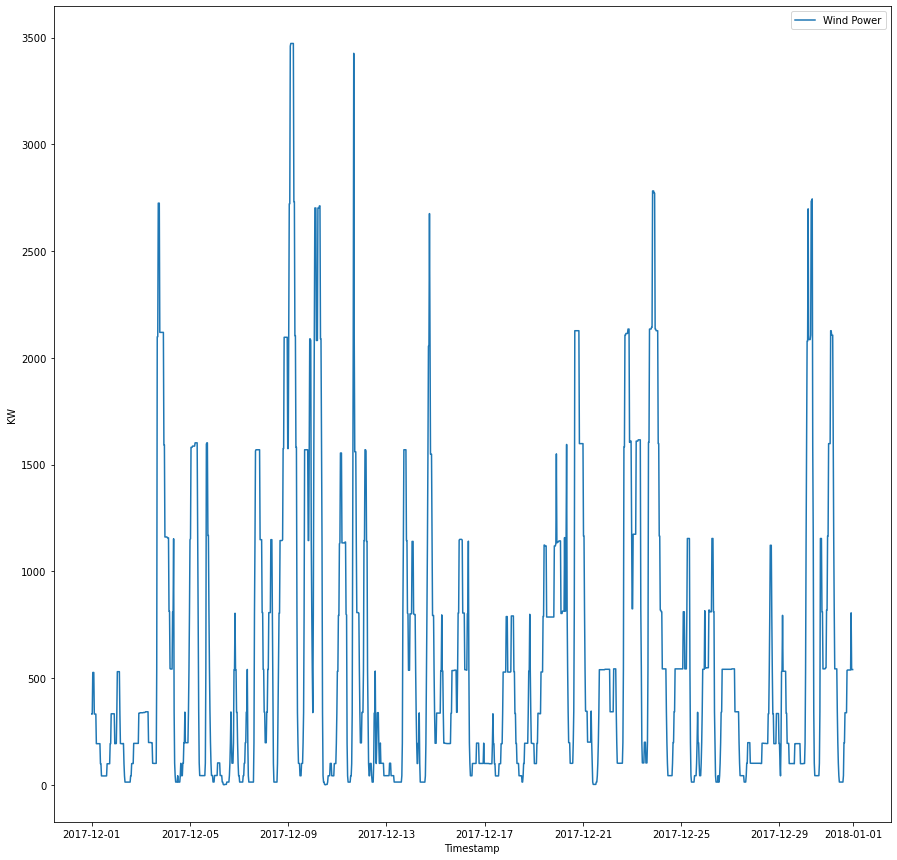

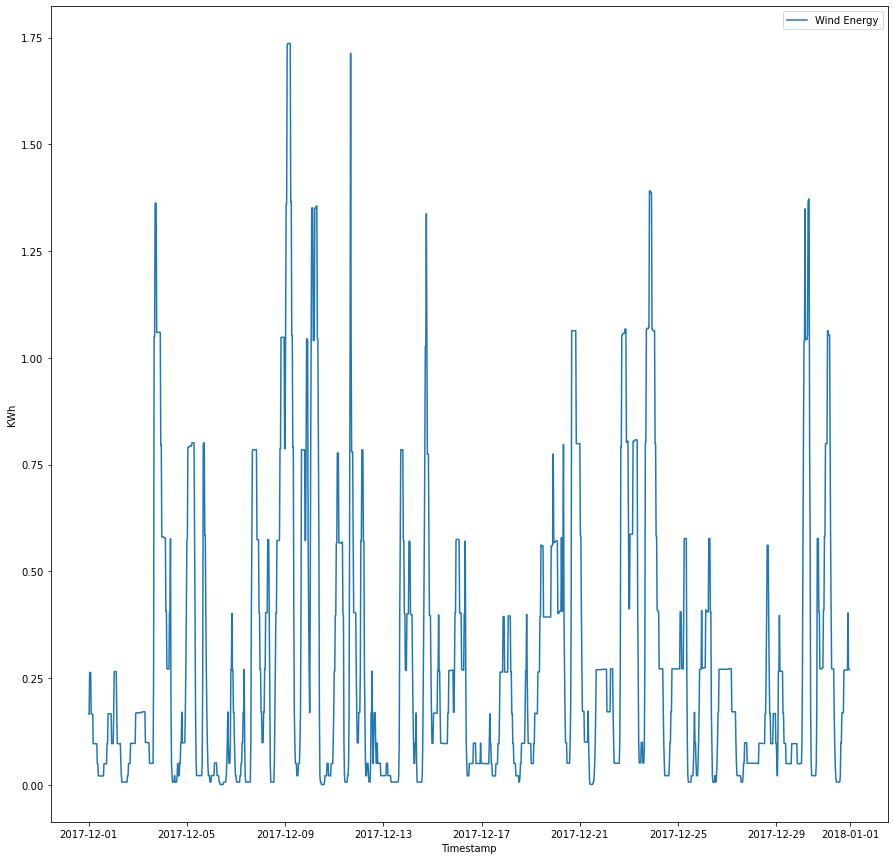

In [28]:
# Plotting line graphs for December 2017
figs, axs = plot_wind(wind_df, wind_feature_units, (15,15))

In [29]:
# Aggregating data points at every 6 hours
wind_df
wind_six_hour_df = wind_df.resample('6H').sum()
wind_six_hour_df

,Pressure,Temperature,Wind Speed,Air Density,Wind Power,Wind Energy
timestamp,,,,,,
2017-12-01 00:00:00,1212000,3346.8,7.2,15.138593,4141.711796,2.070856
2017-12-01 06:00:00,1212000,3349.8,4.8,15.125256,1364.396535,0.682198
2017-12-01 12:00:00,1212000,3356.8,4.2,15.093633,836.301967,0.418151
2017-12-01 18:00:00,1212000,3336.8,6.7,15.183940,3288.925587,1.644463
2017-12-02 00:00:00,1212000,3327.8,7.2,15.225017,4279.316858,2.139658
...,...,...,...,...,...,...
2017-12-30 18:00:00,1230000,3277.8,9.1,15.686796,8586.161068,4.293081
2017-12-31 00:00:00,1230000,3277.8,12.2,15.686796,20509.900633,10.254950
2017-12-31 06:00:00,1224000,3283.8,5.9,15.581874,3434.990578,1.717495


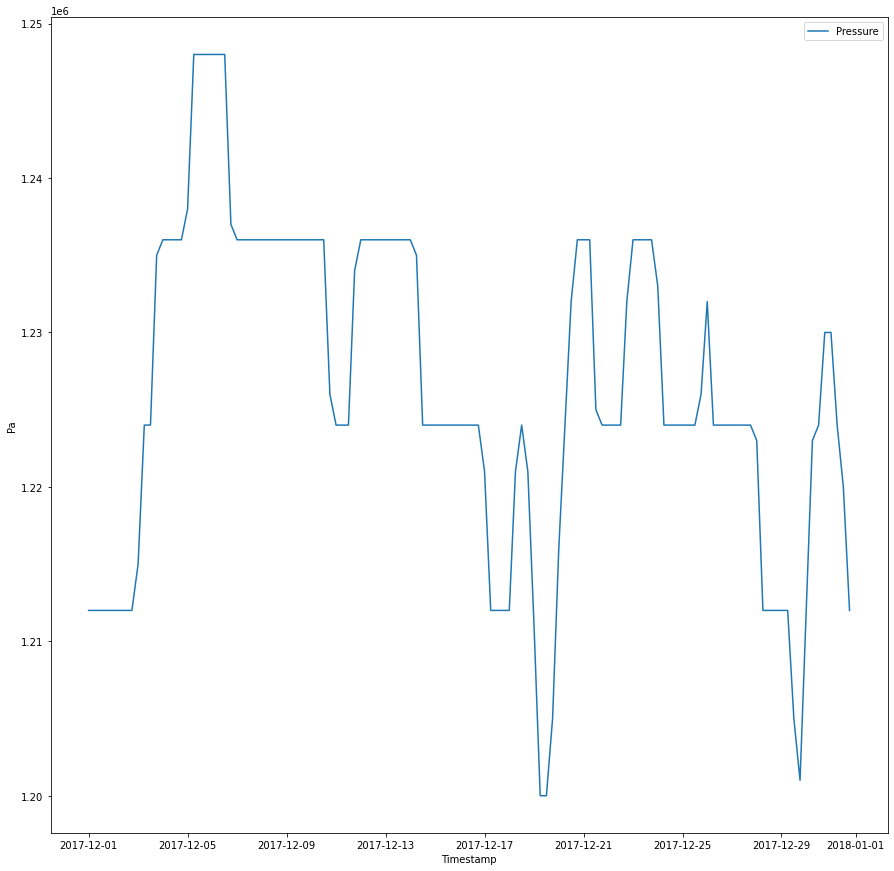

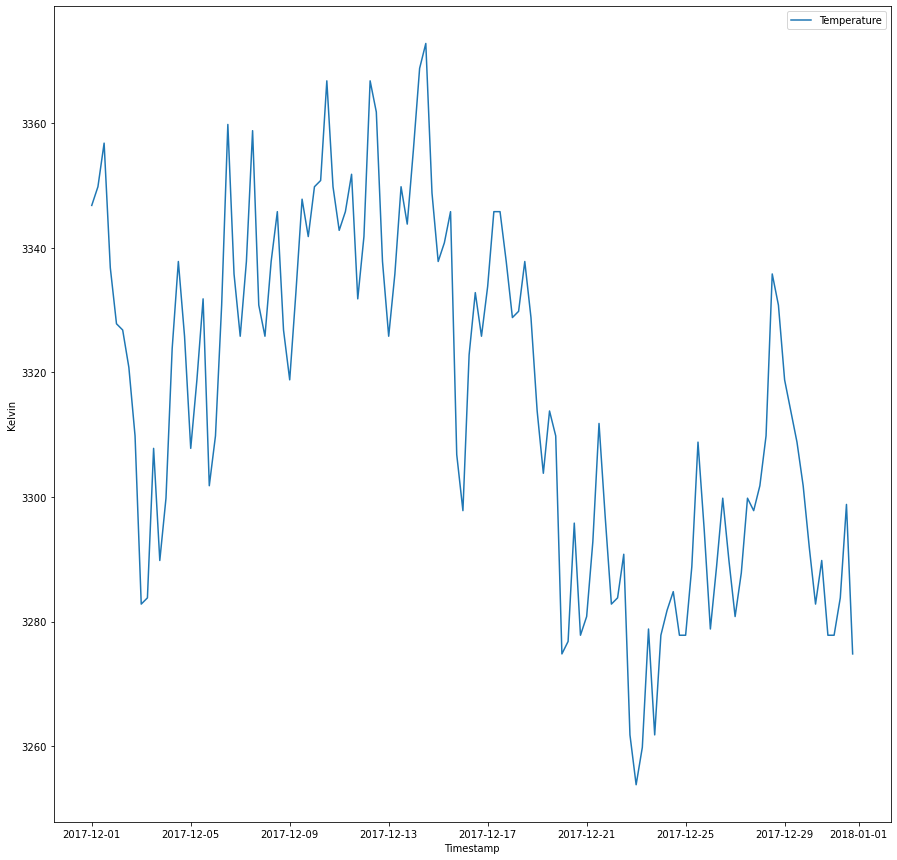

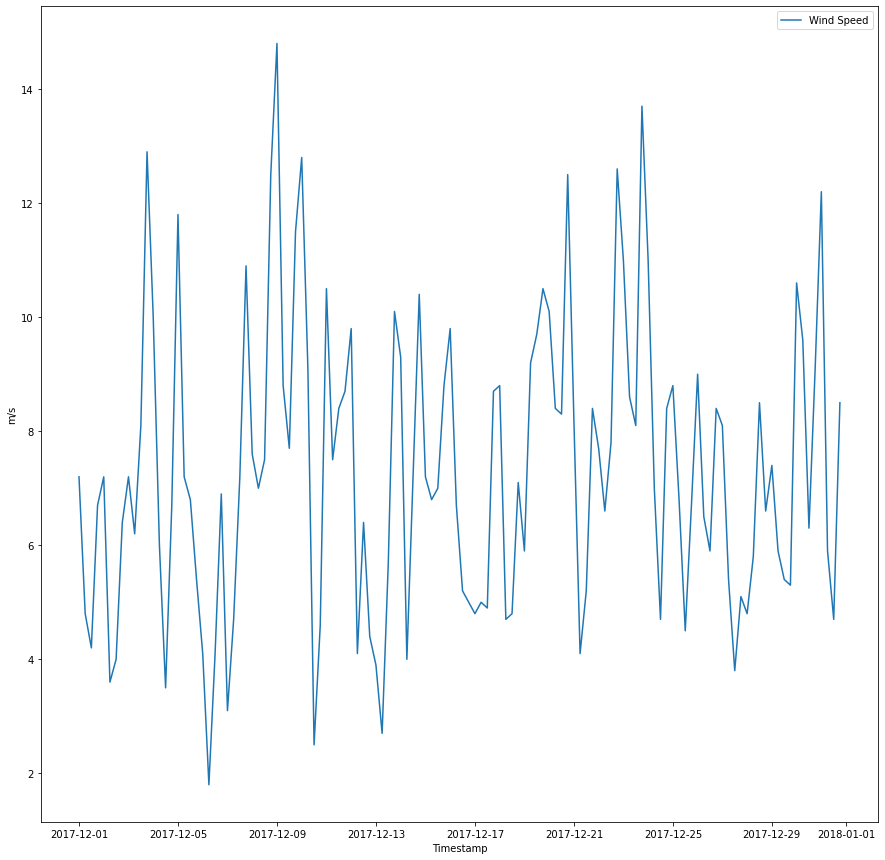

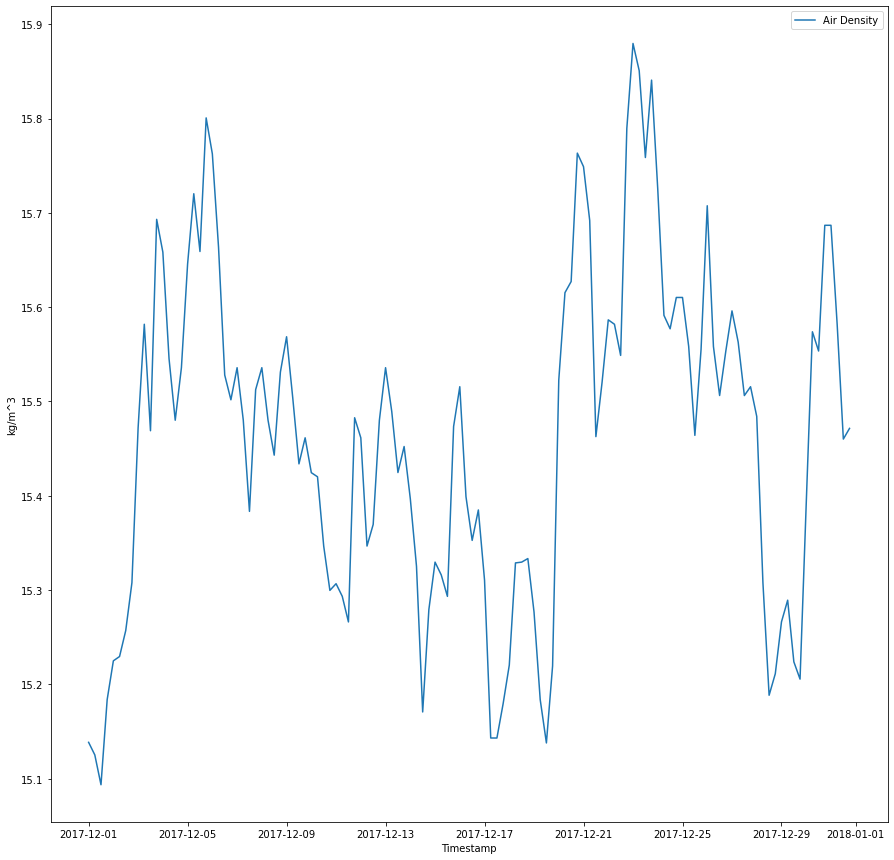

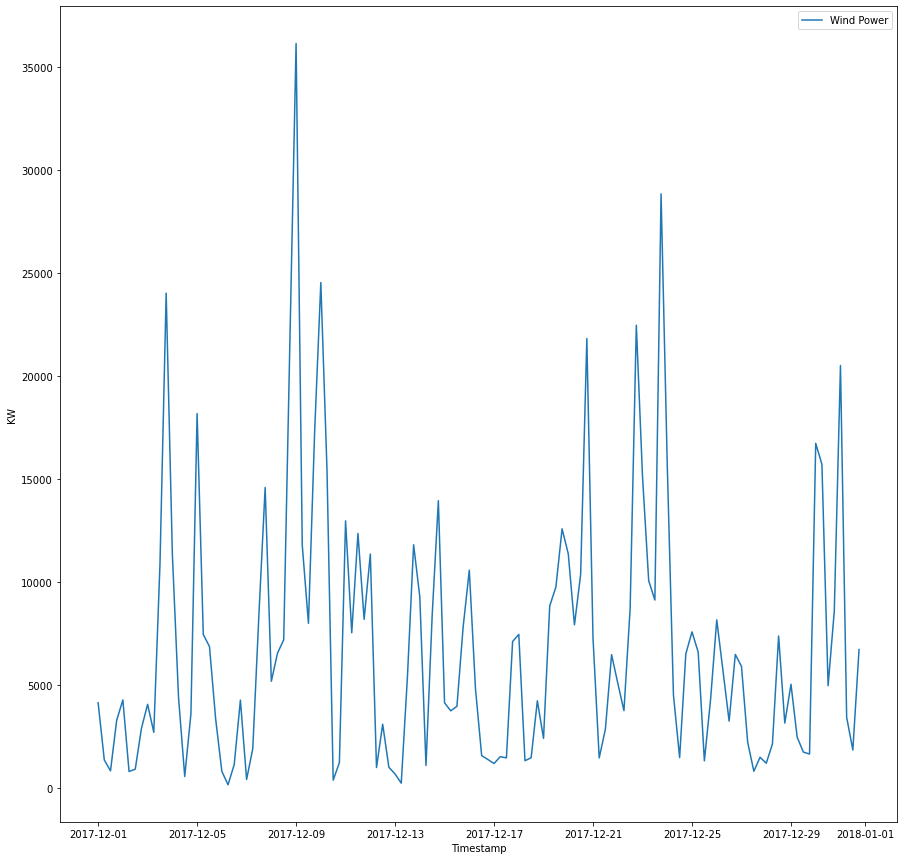

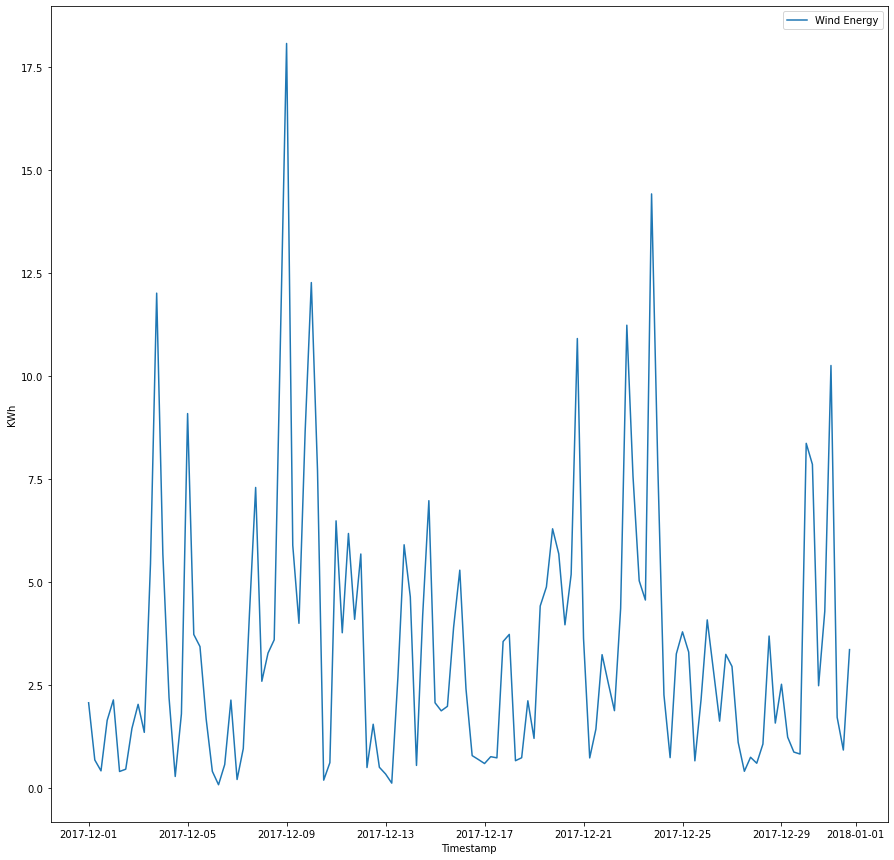

In [30]:
# Plotting line graphs for December 2017
figs, axs = plot_wind(wind_six_hour_df, wind_feature_units, (15,15))